-----
<center>
<h1 style="font-size: 50px; font-family: serif;">AI Driven Environmental Monitoring and Forecasting System 
</h1>
</center>

---

---
# 1. Import Modules 
<span id="Importmodules"></span>

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib
import tensorflow as tf
import os

In [2]:
# Load and preprocess the dataset
train_dir = 'split_data/train'
test_dir = 'split_data/test'

In [3]:
# ImageDataGenerator for loading and augmenting images
datagen = ImageDataGenerator(rescale=1./255)

---
# 2. Load images with augmentation
<span id="Importmodules"></span>

---

In [4]:
# Load images from the training directory
train_data_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Load images from the testing directory
test_data_gen = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Step 1: Load MobileNet as a feature extractor
base_model = MobileNet(weights='imagenet', include_top=False)

# Add a Global Average Pooling layer to extract features
x = base_model.output
x = GlobalAveragePooling2D()(x)
feature_extractor = Model(inputs=base_model.input, outputs=x)

# Freeze the layers of MobileNet to use it as a feature extractor
for layer in base_model.layers:
    layer.trainable = False

# Step 2: Extract features for training and testing data
def extract_features(data_generator):
    features = []
    labels = []
    
    # Loop through batches of images and extract features
    for images, batch_labels in data_generator:
        # Extract features from the MobileNet model
        feature_batch = feature_extractor.predict(images)
        features.append(feature_batch)
        labels.append(batch_labels)
        
        # If we have enough data, stop
        if len(features) * data_generator.batch_size >= data_generator.samples:
            break
    
    # Convert to numpy arrays
    features = np.vstack(features)
    labels = np.vstack(labels)
    return features, labels

# Extract features for train data
X_train_features, y_train_labels = extract_features(train_data_gen)

# Extract features for test data
X_test_features, y_test_labels = extract_features(test_data_gen)

# Step 3: Save the extracted features to .joblib files
joblib.dump((X_train_features, y_train_labels), 'train.joblib')
joblib.dump((X_test_features, y_test_labels), 'test.joblib')

# Step 4: Split the training data into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_features, y_train_labels, test_size=0.2, random_state=42
)

# Optionally, save the split data to .joblib files
joblib.dump((X_train, y_train), 'train_split.joblib')
joblib.dump((X_val, y_val), 'val_split.joblib')

# Saved in 'train.joblib' and 'test.joblib'
print("Features extracted and saved to 'train.joblib' and 'test.joblib'.")

# Let's print the feature shapes for both the train and test datasets after extraction

print(f"Shape of X_train_features: {X_train_features.shape}")
print(f"Shape of y_train_labels: {y_train_labels.shape}")
print(f"Shape of X_test_features: {X_test_features.shape}")
print(f"Shape of y_test_labels: {y_test_labels.shape}")


Found 9799 images belonging to 24 classes.
Found 2401 images belonging to 24 classes.


1/1 [==============================] - 0s 70ms/step
Features extracted and saved to 'train.joblib' and 'test.joblib'.
Shape of X_train_features: (9799, 1024)
Shape of y_train_labels: (9799, 24)
Shape of X_test_features: (2401, 1024)
Shape of y_test_labels: (2401, 24)


---
# 3. Mobilenet Model
<span id="Importmodules"></span>

---

In [5]:
import numpy as np
import joblib
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Load the features extracted previously
X_train_features, y_train_labels = joblib.load('train_split.joblib')
X_val, y_val = joblib.load('val_split.joblib')
X_test_features, y_test_labels = joblib.load('test.joblib')

# If the labels are not already one-hot encoded, we can one-hot encode them
num_classes = y_train_labels.shape[1]  # Number of classes
input_shape = X_train_features.shape[1]  # Number of features per sample (1024 in this case)

# Define the model for classification
input_layer = Input(shape=(input_shape,))  # Shape of the features (1024,)
x = Dropout(0.5)(input_layer)  # Dropout to reduce overfitting
x = Dense(1024, activation='relu')(x)  # Fully connected layer with ReLU activation
x = Dropout(0.5)(x)  # Another Dropout layer
output_layer = Dense(num_classes, activation='softmax')(x)  # Output layer with softmax for multi-class classification

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Print the input and output shapes
print(f"Input shape: {input_shape}")
print(f"Output shape: {num_classes}")

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_features, y_train_labels, 
                    epochs=10, batch_size=32, 
                    validation_data=(X_val, y_val))


Input shape: 1024
Output shape: 24
Epoch 1/10


245/245 [==============================] - 10s 29ms/step - loss: 0.8852 - accuracy: 0.7387 - val_loss: 0.2703 - val_accuracy: 0.9122
Epoch 2/10
245/245 [==============================] - 5s 20ms/step - loss: 0.4287 - accuracy: 0.8631 - val_loss: 0.1931 - val_accuracy: 0.9362
Epoch 3/10
245/245 [==============================] - 5s 20ms/step - loss: 0.3245 - accuracy: 0.8926 - val_loss: 0.1833 - val_accuracy: 0.9439
Epoch 4/10
245/245 [==============================] - 5s 19ms/step - loss: 0.2975 - accuracy: 0.8997 - val_loss: 0.1878 - val_accuracy: 0.9316
Epoch 5/10
245/245 [==============================] - 5s 22ms/step - loss: 0.2787 - accuracy: 0.9065 - val_loss: 0.1629 - val_accuracy: 0.9439
Epoch 6/10
245/245 [==============================] - 6s 24ms/step - loss: 0.2553 - accuracy: 0.9189 - val_loss: 0.1505 - val_accuracy: 0.9474
Epoch 7/10
245/245 [==============================] - 7s 27ms/step - loss: 0.2348 - accuracy: 0.9228 - v

In [6]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 24)                24600     
                                                                 
Total params: 1074200 (4.10 MB)
Trainable params: 1074200 (4.10 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
# Save the trained model
model.save('mobilenet_model.h5')

C:\Users\0860\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


---
# 4. Plot training and validation accuracy
<span id="Importmodules"></span>

---

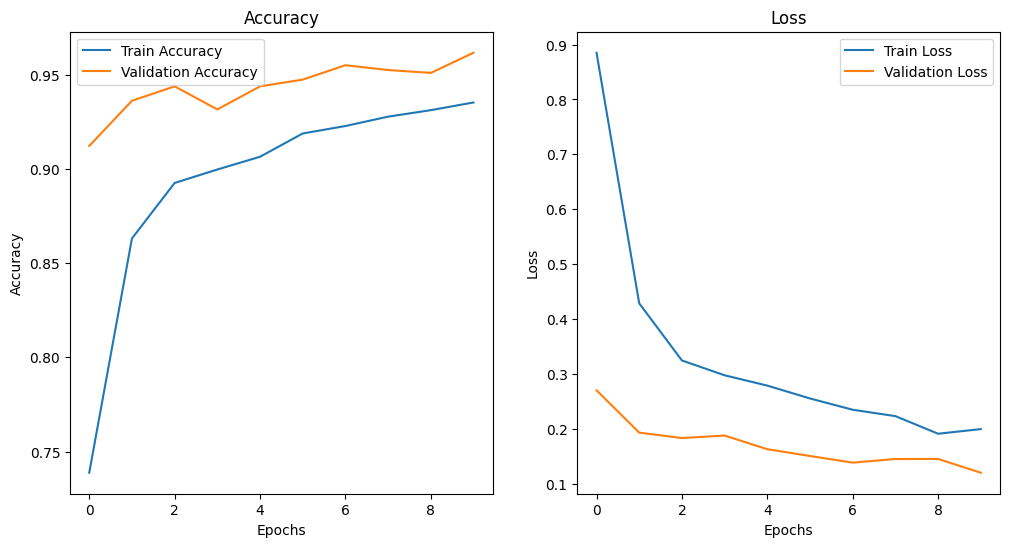

In [8]:
# Plot accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [9]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_features, y_test_labels, verbose=1)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Make predictions on the test set
y_pred = model.predict(X_test_features)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_labels, axis=1)

76/76 [==============================] - 0s 3ms/step - loss: 0.1222 - accuracy: 0.9600
Test accuracy: 0.9600
Test loss: 0.1222
76/76 [==============================] - 0s 3ms/step


---
# 5. Confusion Matrix and Classification Report
<span id="Importmodules"></span>

---

Confusion Matrix:
[[100   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0  99   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0 100   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0  99   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    1   0   0   0   0   0]
 [  0   0   0   0  90   0   0   4   0   0   0   0   0   0   1   3   1   0
    0   0   0   1   0   0]
 [  0   0   0   0   0  97   0   0   0   3   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0 100   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   5   0   0  80   0   0   0   0   0   0  14   1   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 100   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  99   0   1   0   0   0   0   0   0

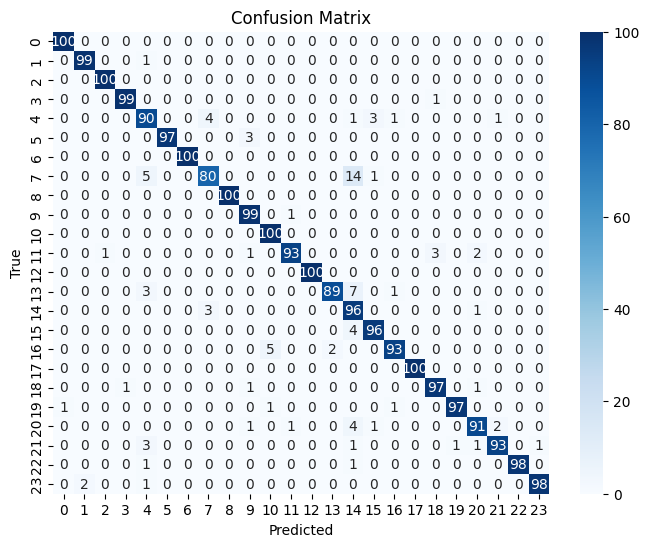

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_true_classes, y_pred_classes)
print("Classification Report:")
print(class_report)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

---
# 6. Hybrid Model(CNN and LSTM)
<span id="Importmodules"></span>

---

In [11]:
import numpy as np
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load data
X_train_features, y_train_labels = joblib.load('train_split.joblib')
X_val, y_val = joblib.load('val_split.joblib')
X_test_features, y_test_labels = joblib.load('test.joblib')

# Parameters
time_steps = 32  # divide 1024 into 32 steps
input_features = X_train_features.shape[1]  # 1024
channels = input_features // time_steps  # = 32

# Reshape
X_train_reshaped = X_train_features.reshape((-1, time_steps, channels))
X_val_reshaped = X_val.reshape((-1, time_steps, channels))
X_test_reshaped = X_test_features.reshape((-1, time_steps, channels))

print(f"X_train_reshaped shape: {X_train_reshaped.shape}")

# Build the CNN + LSTM model
model = Sequential()

# 1D Convolution Layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_steps, channels)))
model.add(MaxPooling1D(pool_size=2))

# Optional: Add another Conv1D layer
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# LSTM layer
model.add(LSTM(128, return_sequences=False))

# Dropout for regularization
model.add(Dropout(0.5))

# Dense layers
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train_labels.shape[1], activation='softmax'))

# Compile model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train_reshaped, y_train_labels,
                    epochs=20, batch_size=32,
                    validation_data=(X_val_reshaped, y_val))


X_train_reshaped shape: (7839, 32, 32)
Epoch 1/20
245/245 [==============================] - 8s 13ms/step - loss: 2.1671 - accuracy: 0.3064 - val_loss: 1.2161 - val_accuracy: 0.5724
Epoch 2/20
245/245 [==============================] - 2s 9ms/step - loss: 1.0938 - accuracy: 0.6248 - val_loss: 0.8958 - val_accuracy: 0.6867
Epoch 3/20
245/245 [==============================] - 3s 12ms/step - loss: 0.7658 - accuracy: 0.7461 - val_loss: 0.6143 - val_accuracy: 0.7898
Epoch 4/20
245/245 [==============================] - 3s 14ms/step - loss: 0.5410 - accuracy: 0.8222 - val_loss: 0.5572 - val_accuracy: 0.8056
Epoch 5/20
245/245 [==============================] - 3s 11ms/step - loss: 0.3947 - accuracy: 0.8729 - val_loss: 0.4234 - val_accuracy: 0.8561
Epoch 6/20
245/245 [==============================] - 2s 10ms/step - loss: 0.3048 - accuracy: 0.9002 - val_loss: 0.3729 - val_accuracy: 0.8745
Epoch 7/20
245/245 [==============================] - 3s 11ms/step - loss: 0.2496 - accuracy: 0.9187 - v

In [12]:
# Save the model
model.save('cnn_lstm_model.h5')

C:\Users\0860\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test_labels)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

76/76 [==============================] - 0s 4ms/step - loss: 0.4008 - accuracy: 0.9059
Test accuracy: 0.9059
Test loss: 0.4008


---
# 7. Plot training and validation accuracy
<span id="Importmodules"></span>

---

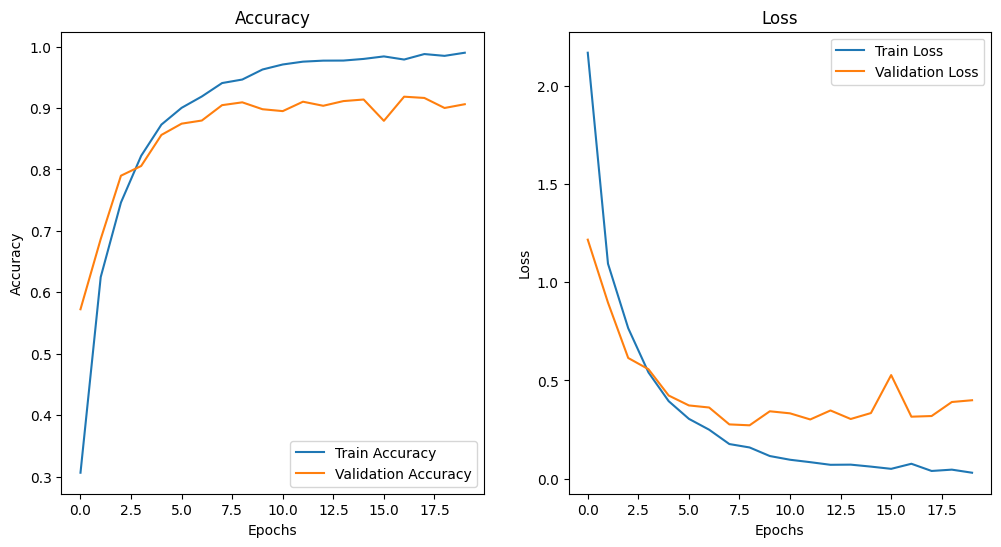

In [14]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

---
# 8. Confusion Matrix and Classification Report
<span id="Importmodules"></span>

---

76/76 [==============================] - 1s 4ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95       100
           1       0.97      0.95      0.96       100
           2       0.82      0.98      0.89       100
           3       1.00      0.90      0.95       100
           4       0.72      0.83      0.77       100
           5       1.00      0.97      0.98       100
           6       1.00      0.99      0.99       100
           7       0.83      0.71      0.76       100
           8       1.00      1.00      1.00       100
           9       0.96      0.96      0.96       100
          10       0.90      0.97      0.93       100
          11       0.90      0.87      0.88       100
          12       0.99      0.98      0.98       100
          13       1.00      0.71      0.83       100
          14       0.83      0.71      0.76       100
          15       0.81      0.93      0.87       100
    

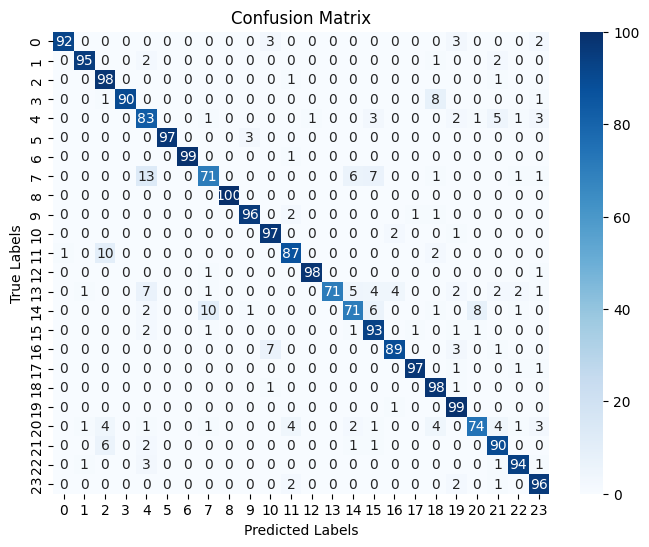

In [15]:
# Predict on the test data
y_pred = model.predict(X_test_reshaped)

# Convert predictions and true labels from one-hot encoding to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_labels, axis=1)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [16]:
# Extract class names from the training data generator
class_indices = train_data_gen.class_indices  # This gives a dictionary mapping class names to indices
class_names = [key for key, _ in sorted(class_indices.items(), key=lambda item: item[1])]

print("Class Names:", class_names)


Class Names: ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'cloudy', 'denseresidential', 'desert', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt', 'unknow']


In [17]:
# import os
# import shutil
# from sklearn.model_selection import train_test_split

# def split_data(input_folder, output_folder, test_size=0.2):
#     """
#     Splits the data in the input folder into train and test sets and saves them in the output folder.

#     Parameters:
#         input_folder (str): Path to the folder containing the dataset.
#         output_folder (str): Path to save the train and test datasets.
#         test_size (float): Proportion of the dataset to include in the test split.
#     """
#     # Create output folders for train and test
#     train_folder = os.path.join(output_folder, 'train')
#     test_folder = os.path.join(output_folder, 'test')

#     os.makedirs(train_folder, exist_ok=True)
#     os.makedirs(test_folder, exist_ok=True)

#     # Iterate through each class folder
#     for class_name in os.listdir(input_folder):
#         class_folder = os.path.join(input_folder, class_name)

#         if os.path.isdir(class_folder):
#             # Get all files in the class folder
#             files = [f for f in os.listdir(class_folder) if os.path.isfile(os.path.join(class_folder, f))]

#             # Split files into train and test
#             train_files, test_files = train_test_split(files, test_size=test_size, random_state=42)

#             # Create class folders in train and test directories
#             train_class_folder = os.path.join(train_folder, class_name)
#             test_class_folder = os.path.join(test_folder, class_name)

#             os.makedirs(train_class_folder, exist_ok=True)
#             os.makedirs(test_class_folder, exist_ok=True)

#             # Copy files to train and test folders
#             for file in train_files:
#                 shutil.copy(os.path.join(class_folder, file), os.path.join(train_class_folder, file))

#             for file in test_files:
#                 shutil.copy(os.path.join(class_folder, file), os.path.join(test_class_folder, file))

#     print(f"Data split completed. Train and test sets saved in '{output_folder}'.")

# # Example usage
# input_folder = "Dataset"  
# output_folder = "split_data"      
# test_size = 0.2                       

# split_data(input_folder, output_folder, test_size)